## Chapter 2-3, 2. 시계열 예측 모델링 — 회귀(선형/랜덤포레스트), 시계열 전용(SARIMA/Prophet), 딥러닝(LSTM) (Bike Sharing)

- **목표**: 회귀(선형/랜덤포레스트), 시계열 전용(SARIMA/Prophet), 딥러닝(LSTM) 모델을 단계별로 학습·평가하여 비교합니다.
- **데이터**: Kaggle Bike Sharing Demand (시간 단위, `count` 대상)
- **규칙(강의용)**: `matplotlib`만 사용 (seaborn X), 색상 지정 X, 서브플롯 X


#### 구성
- 시계열 예측의 중요성과 활용: 수요/재고/인력/교통/에너지 등
- 일반 회귀 vs 시계열 모델 차이: IID 가정 vs 자기상관/계절성/추세
- 실습을 통한 모델 성능 비교 학습 및 해석


### 0. 환경 준비 및 라이브러리 임포트

- 시각화는 `matplotlib`만 사용합니다.
- 회귀 모델(`scikit-learn`), 시계열(`statsmodels`), Prophet(선택)을 사용합니다.
- 한글 폰트와 경고 억제를 설정합니다.


In [1]:
# -*- coding: utf-8 -*-
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.statespace.sarimax import SARIMAX

try:
    from prophet import Prophet
    _HAS_PROPHET = True
except Exception:
    _HAS_PROPHET = False

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", message=r"Glyph.*missing from font.*", category=UserWarning)

# 한글 폰트 설정 및 마이너스 기호 깨짐 방지 (후보군을 sans-serif 우선순위로 지정)
def _set_korean_font() -> None:
    font_candidates = [
        "AppleGothic",
        "NanumGothic",
        "Malgun Gothic",
        "Noto Sans CJK KR",
        "Noto Sans KR",
        "DejaVu Sans",
    ]
    # 우선순위 리스트를 그대로 등록하여 사용 가능한 항목으로 대체되도록 함
    plt.rcParams["font.family"] = "sans-serif"
    plt.rcParams["font.sans-serif"] = font_candidates
    plt.rcParams["axes.unicode_minus"] = False

_set_korean_font()

pd.set_option('display.max_columns', 100)


/Users/kimjinseok/Desktop/metacode-lecture/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


### 1. 데이터 준비 및 전처리
- `bike-sharing-demand/train.csv` 로드, `datetime` 파싱/정렬
- 시간 파생변수 생성(년/월/일/요일/시간)
- 시간 순서대로 train/val/test 분할


In [2]:
def load_hourly_data():
    # 데이터 파일 경로 지정
    path = 'bike-sharing-demand/train.csv'
    
    # 파일이 존재하지 않을 경우 에러 발생
    if not os.path.exists(path):
        raise FileNotFoundError('train.csv 경로를 찾을 수 없습니다.')
    
    # CSV 파일을 불러오기
    df = pd.read_csv(path)
    
    # datetime 컬럼을 datetime 형식으로 변환
    df['datetime'] = pd.to_datetime(df['datetime'])
    
    # 시간 순으로 정렬 후 인덱스 재설정
    df = df.sort_values('datetime').reset_index(drop=True)
    
    # 사용할 컬럼만 선택
    cols = ['datetime','season','holiday','workingday','weather',
            'temp','atemp','humidity','windspeed',
            'casual','registered','count']
    return df[cols]


def add_time_features(df: pd.DataFrame) -> pd.DataFrame:
    # 입력된 DataFrame을 복사하여 새로운 데이터프레임 생성
    out = df.copy()
    
    # datetime에서 파생된 시간 관련 특징 추가
    out['year'] = out['datetime'].dt.year        # 연도
    out['month'] = out['datetime'].dt.month      # 월
    out['day'] = out['datetime'].dt.day          # 일
    out['dayofweek'] = out['datetime'].dt.dayofweek  # 요일 (0=월요일, 6=일요일)
    out['hour'] = out['datetime'].dt.hour        # 시(hour)
    
    return out


def split_by_time(df: pd.DataFrame, train_ratio: float = 0.8, val_ratio: float = 0.1):
    # 전체 데이터 크기
    n = len(df)
    
    # 훈련/검증 데이터 크기 계산
    n_train = int(n * train_ratio)
    n_val = int(n * val_ratio)
    
    # 시간 순으로 train/val/test 나누기
    train = df.iloc[:n_train]                    # 앞부분 → train
    val = df.iloc[n_train:n_train+n_val]         # 중간 → validation
    test = df.iloc[n_train+n_val:]               # 나머지 → test
    
    return train, val, test


# --- 실행 부분 ---

# 데이터 불러오기
df = load_hourly_data()
print('데이터 크기:', df.shape, '기간:', df['datetime'].min(), '→', df['datetime'].max())

# 시간 파생 변수 추가
df_feat = add_time_features(df)

# 결측치 보간 (앞/뒤 값으로 채우기)
df = df.ffill().bfill()

# train, validation, test 데이터 분할
train_df, val_df, test_df = split_by_time(df_feat)


데이터 크기: (10886, 12) 기간: 2011-01-01 00:00:00 → 2012-12-19 23:00:00


### 2-1. 일반 회귀 베이스라인: 선형 회귀 vs 랜덤포레스트
- 입력: 시간 파생 + 기상/상태 변수, 타깃: `count`
- 평가: MAE/MSE/RMSE/R^2


In [3]:
def to_supervised_features(df: pd.DataFrame, target: str = 'count'):
    # 사용할 기본 특징 컬럼 정의
    feature_cols = [
        'season','holiday','workingday','weather',
        'temp','atemp','humidity','windspeed',
        'year','month','day','dayofweek','hour'
    ]
    
    # 특징 변수(X) 선택
    X = df[feature_cols].copy()
    
    # 범주형 변수(season, holiday, workingday, weather, year, month, dayofweek, hour)를 원-핫 인코딩
    # drop_first=False : 첫 번째 카테고리도 유지 (모든 더미 변수를 포함)
    X = pd.get_dummies(
        X, 
        columns=['season','holiday','workingday','weather','year','month','dayofweek','hour'], 
        drop_first=False
    )
    
    # 타겟 변수(y) 선택 (float형으로 변환)
    y = df[target].astype(float)
    
    return X, y


def compute_metrics(y_true, y_pred):
    # 성능 지표 계산
    mae  = float(mean_absolute_error(y_true, y_pred))  # 평균 절대 오차
    mse  = float(mean_squared_error(y_true, y_pred))   # 평균 제곱 오차
    rmse = float(np.sqrt(mse))                         # RMSE = MSE의 제곱근
    r2   = r2_score(y_true, y_pred)                    # 결정계수 (설명된 분산 비율)
    
    # 결과 출력
    print("[Metrics]")
    print(f"MAE  : {mae:.6f} - 평균 절대 오차")
    print(f"MSE  : {mse:.6f} - 평균 제곱 오차")
    print(f"RMSE : {rmse:.6f} - 제곱근 평균 제곱 오차")
    print(f"R^2  : {r2:.6f} - 결정계수(설명된 분산 비율)")
    
    return mae, mse, rmse, r2


def plot_actual_vs_pred(dt_index, y_true, y_pred, title):
    # 실제값 vs 예측값 시계열 비교 시각화
    plt.figure(figsize=(12,4))
    plt.plot(dt_index, y_true, label='Actual')   # 실제값
    plt.plot(dt_index, y_pred, label='Pred')     # 예측값
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Count')
    plt.legend()
    plt.tight_layout()
    plt.show()


# -----------------------------
# Train / Validation / Test 데이터별 특징 생성
# -----------------------------
X_train, y_train = to_supervised_features(train_df)  # 학습 데이터
X_val, y_val     = to_supervised_features(val_df)    # 검증 데이터
X_test, y_test   = to_supervised_features(test_df)   # 테스트 데이터

# 학습 데이터에서 생성된 컬럼 구조에 맞추어 Validation/Test 데이터 보정
# → 학습 때 나온 컬럼과 Validation/Test 컬럼이 동일해야 함
# → 없는 컬럼은 fill_value=0 으로 채움
X_val  = X_val.reindex(columns=X_train.columns, fill_value=0)
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)


[Metrics]
MAE  : 112.461157 - 평균 절대 오차
MSE  : 21701.572466 - 평균 제곱 오차
RMSE : 147.314536 - 제곱근 평균 제곱 오차
R^2  : 0.611101 - 결정계수(설명된 분산 비율)
Linear/VAL (112.46115659982183, 21701.5724664791, 147.3145358288825, 0.6111009463256456)
[Metrics]
MAE  : 84.412417 - 평균 절대 오차
MSE  : 12720.204474 - 평균 제곱 오차
RMSE : 112.783884 - 제곱근 평균 제곱 오차
R^2  : 0.662295 - 결정계수(설명된 분산 비율)
Linear/TEST (84.41241701047062, 12720.204474477732, 112.78388393062961, 0.6622946885094285)


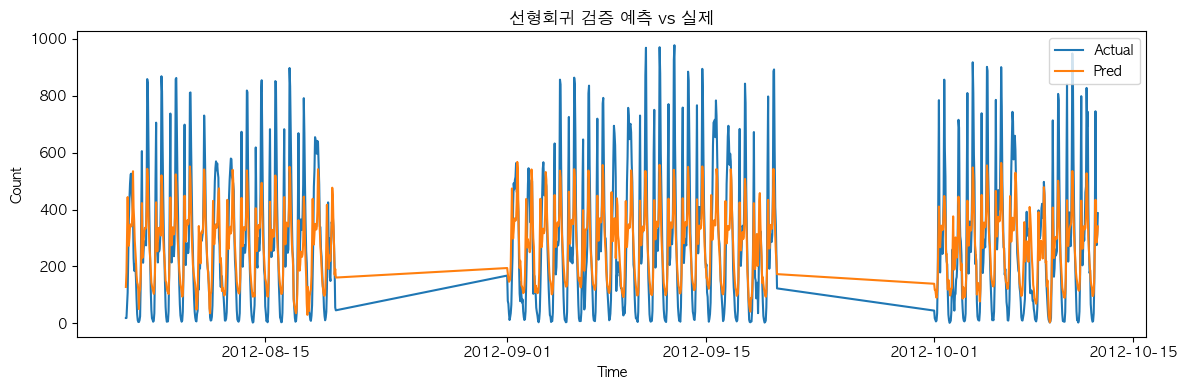

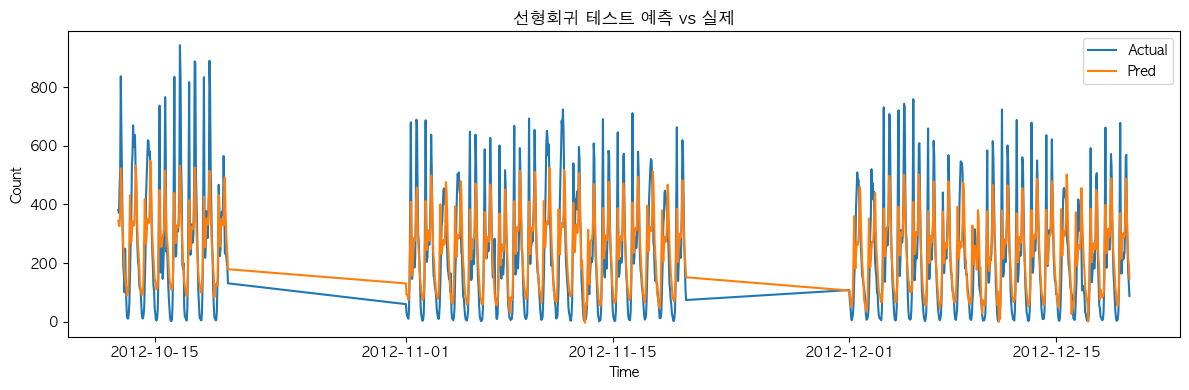

[Metrics]
MAE  : 59.311357 - 평균 절대 오차
MSE  : 8326.449294 - 평균 제곱 오차
RMSE : 91.249380 - 제곱근 평균 제곱 오차
R^2  : 0.850787 - 결정계수(설명된 분산 비율)
RF/VAL (59.31135723039216, 8326.449294475082, 91.2493796936455, 0.8507873908173891)
[Metrics]
MAE  : 68.762976 - 평균 절대 오차
MSE  : 10117.330518 - 평균 제곱 오차
RMSE : 100.584942 - 제곱근 평균 제곱 오차
R^2  : 0.731398 - 결정계수(설명된 분산 비율)
RF/TEST (68.76297553516821, 10117.330518318044, 100.58494180700232, 0.7313976940388813)


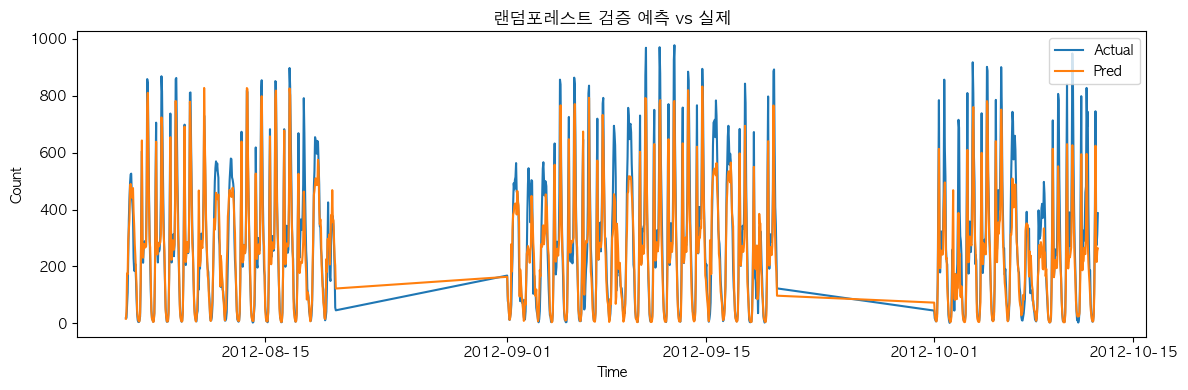

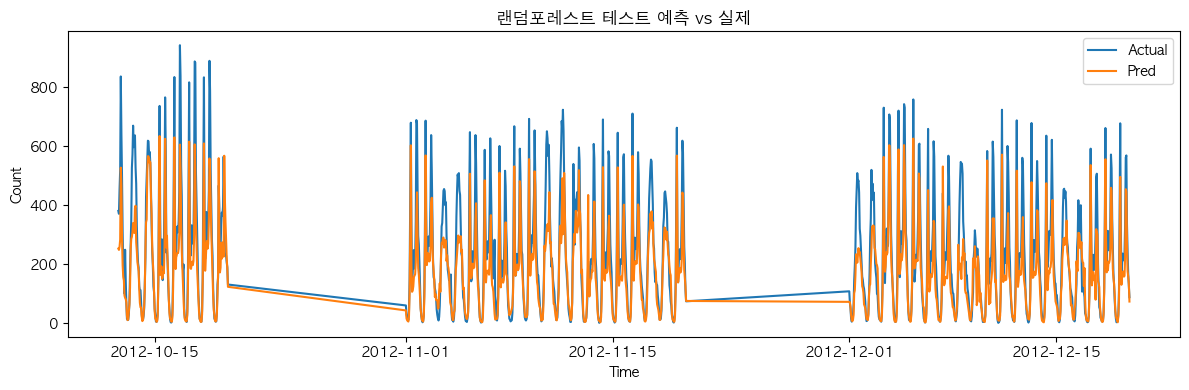

RF 중요도 TOP 15:
 atemp           0.186645
hour_17         0.094062
humidity        0.084904
hour_18         0.079720
hour_8          0.055163
workingday_0    0.047907
workingday_1    0.047481
temp            0.041277
year_2011       0.030997
year_2012       0.030407
hour_19         0.030261
hour_7          0.016440
hour_2          0.015388
hour_1          0.015234
day             0.014464
dtype: float64


In [4]:
# -----------------------------
# 선형 회귀 (Linear Regression)
# -----------------------------
from sklearn.linear_model import LinearRegression

# 선형 회귀 모델 학습 (train 데이터로 적합)
lin = LinearRegression().fit(X_train, y_train)

# 검증 데이터 예측
lin_val_pred  = lin.predict(X_val)

# 테스트 데이터 예측
lin_test_pred = lin.predict(X_test)

# 성능 평가 (검증/테스트)
print('Linear/VAL', compute_metrics(y_val.to_numpy(), lin_val_pred))   # 검증 데이터 지표
print('Linear/TEST', compute_metrics(y_test.to_numpy(), lin_test_pred)) # 테스트 데이터 지표

# 실제값 vs 예측값 시각화 (검증)
plot_actual_vs_pred(
    val_df['datetime'].values, y_val.to_numpy(), lin_val_pred, 
    '선형회귀 검증 예측 vs 실제'
)

# 실제값 vs 예측값 시각화 (테스트)
plot_actual_vs_pred(
    test_df['datetime'].values, y_test.to_numpy(), lin_test_pred, 
    '선형회귀 테스트 예측 vs 실제'
)


# -----------------------------
# 랜덤 포레스트 회귀 (RandomForestRegressor)
# -----------------------------
rf = RandomForestRegressor(
    n_estimators=300,   # 트리 개수 (기본값보다 크게 설정 → 성능 안정화)
    n_jobs=-1,          # CPU 코어 모두 사용
    random_state=42     # 재현성을 위한 시드 고정
)

# 모델 학습
rf.fit(X_train, y_train)

# 검증 데이터 예측
rf_val_pred = rf.predict(X_val)

# 테스트 데이터 예측
rf_test_pred = rf.predict(X_test)

# 성능 평가 (검증/테스트)
print('RF/VAL', compute_metrics(y_val.to_numpy(), rf_val_pred))   # 검증 데이터 지표
print('RF/TEST', compute_metrics(y_test.to_numpy(), rf_test_pred)) # 테스트 데이터 지표

# 실제값 vs 예측값 시각화 (검증)
plot_actual_vs_pred(
    val_df['datetime'].values, y_val.to_numpy(), rf_val_pred, 
    '랜덤포레스트 검증 예측 vs 실제'
)

# 실제값 vs 예측값 시각화 (테스트)
plot_actual_vs_pred(
    test_df['datetime'].values, y_test.to_numpy(), rf_test_pred, 
    '랜덤포레스트 테스트 예측 vs 실제'
)


# -----------------------------
# 랜덤 포레스트 특징 중요도 확인
# -----------------------------
try:
    # feature_importances_ 속성을 이용해 변수 중요도 계산
    importances = (
        pd.Series(rf.feature_importances_, index=X_train.columns)
        .sort_values(ascending=False)
    )
    
    # 상위 15개 특징 출력
    print('RF 중요도 TOP 15:\n', importances.head(15))
except Exception:
    # 만약 feature_importances_가 없거나 오류 발생 시 무시
    pass



### 2-2. 하이퍼파라미터 최적화 & 시계열 교차검증
- `TimeSeriesSplit`을 이용한 교차검증
- 랜덤포레스트 간단 Grid Search


In [5]:
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
#from sklearn.ensemble import RandomForestRegressor

# -----------------------------
# 0) 전체 피처/타깃 생성
# -----------------------------
X_all_ts, y_all_ts = to_supervised_features(df_feat)  # 전체 데이터에서 특징(X), 타깃(y) 생성

# (선택) 인덱스가 섞여 있다면 시간순 정렬 필요
# X_all_ts = X_all_ts.sort_index()
# y_all_ts = y_all_ts.loc[X_all_ts.index]

# -----------------------------
# 1) 홀드아웃 분할 (마지막 20%를 최종 테스트셋으로 보존)
# -----------------------------
split_idx = int(len(X_all_ts) * 0.8)   # 80% 시점 기준 분할

# 교차검증(CV)에 사용할 구간
X_cv_ts,  y_cv_ts   = X_all_ts.iloc[:split_idx], y_all_ts.iloc[:split_idx]

# 최종 테스트 구간 (학습/튜닝에 사용하지 않음 → 완전 unseen data)
X_test_ts, y_test_ts = X_all_ts.iloc[split_idx:], y_all_ts.iloc[split_idx:]

print(f"[SHAPE] X_cv_ts={X_cv_ts.shape}, y_cv_ts={y_cv_ts.shape}, "
      f"X_test_ts={X_test_ts.shape}, y_test_ts={y_test_ts.shape}")


# -----------------------------
# 2) 시계열 교차검증 분할기 (TimeSeriesSplit)
# -----------------------------
# 일반 KFold와 달리, 미래 데이터를 학습에 쓰지 않도록 시간 순서를 보존하는 방식
tscv_cv = TimeSeriesSplit(n_splits=5)  # 5겹 시계열 교차검증


# -----------------------------
# 3) 하이퍼파라미터 그리드 & GridSearchCV 객체 생성
# -----------------------------
param_grid_rf = {
    "n_estimators": [200, 300],   # 트리 개수
    "max_depth": [None, 12, 24]   # 트리 깊이
}

# 랜덤포레스트 기본 모델
rf_base = RandomForestRegressor(random_state=42, n_jobs=-1)

# GridSearchCV로 하이퍼파라미터 탐색
rf_gs_cv = GridSearchCV(
    estimator=rf_base,
    param_grid=param_grid_rf,
    cv=tscv_cv,                          # 시계열 분할기로 교차검증
    scoring='neg_root_mean_squared_error',  # RMSE (scikit-learn은 음수로 반환)
    n_jobs=-1                            # 병렬 처리
)


# -----------------------------
# 4) CV 구간 데이터로 그리드서치 실행
# -----------------------------
rf_gs_cv.fit(X_cv_ts, y_cv_ts)

# 최적 하이퍼파라미터 및 교차검증 RMSE 출력
print('최적 하이퍼파라미터(CV):', rf_gs_cv.best_params_)
print('CV RMSE:', -rf_gs_cv.best_score_)  # neg RMSE → 부호 반전


# -----------------------------
# 5) 최적 모델을 CV 구간 전체 데이터로 재학습
# -----------------------------
rf_best_cv_ts = rf_gs_cv.best_estimator_
rf_best_cv_ts.fit(X_cv_ts, y_cv_ts)


# -----------------------------
# 6) 최종 테스트셋 평가 (홀드아웃)
# -----------------------------
y_pred_test_ts = rf_best_cv_ts.predict(X_test_ts)

# 평가 지표 계산
mae_ts  = mean_absolute_error(y_test_ts, y_pred_test_ts)
mse_ts  = mean_squared_error(y_test_ts, y_pred_test_ts)
rmse_ts = np.sqrt(mse_ts)
r2_ts   = r2_score(y_test_ts, y_pred_test_ts)

print("\n[TEST Metrics - Time Series Holdout]")
print(f"MAE  : {mae_ts:.3f}")
print(f"MSE  : {mse_ts:.3f}")
print(f"RMSE : {rmse_ts:.3f}")
print(f"R^2  : {r2_ts:.3f}")



[SHAPE] X_cv_ts=(8708, 62), y_cv_ts=(8708,), X_test_ts=(2178, 62), y_test_ts=(2178,)
최적 하이퍼파라미터(CV): {'max_depth': None, 'n_estimators': 200}
CV RMSE: 93.78490562597392

[TEST Metrics - Time Series Holdout]
MAE  : 63.831
MSE  : 9158.992
RMSE : 95.703
R^2  : 0.807


In [6]:
def plot_timeseries_split(n_samples=30, n_splits=5):
    """
    TimeSeriesSplit이 데이터를 어떻게 분할하는지 시각적으로 보여주는 함수
    
    Parameters%
    ----------
    n_samples : int
        전체 데이터 샘플 수 (예: len(X_all))
    n_splits : int
        TimeSeriesSplit의 분할 개수 (fold 수)
    """
    # 샘플 인덱스 (0 ~ n_samples-1 까지)
    X = range(n_samples)
    
    # 시계열 교차검증 분할기 생성
    tscv = TimeSeriesSplit(n_splits=n_splits)

    # 그래프 크기 지정
    plt.figure(figsize=(12, 6))

    # TimeSeriesSplit에서 fold별 train/test 인덱스 추출
    for fold, (train_idx, test_idx) in enumerate(tscv.split(X), 1):
        # 🔹 Train 부분 (파란색 원)
        plt.scatter(
            train_idx,                # 훈련 인덱스
            [fold]*len(train_idx),    # y축은 fold 번호로 고정
            marker='o', color='blue', s=40,
            label='Train' if fold == 1 else ""  # 첫 번째 fold만 범례 추가
        )
        
        # 🔹 Test 부분 (빨간색 원)
        plt.scatter(
            test_idx, 
            [fold]*len(test_idx), 
            marker='o', color='red', s=40,
            label='Test' if fold == 1 else ""   # 첫 번째 fold만 범례 추가
        )

    # y축: Fold 번호 표시
    plt.yticks(range(1, n_splits+1), [f"Fold {i}" for i in range(1, n_splits+1)])
    
    # x축/ y축 라벨
    plt.xlabel("Index (시간 순서)")
    plt.ylabel("CV Fold")
    
    # 그래프 제목
    plt.title(f"TimeSeriesSplit 시각화 (샘플 {n_samples}, 분할 {n_splits})")
    
    # 범례 및 그리드 표시
    plt.legend()
    plt.grid(True)
    
    # 출력
    plt.show()


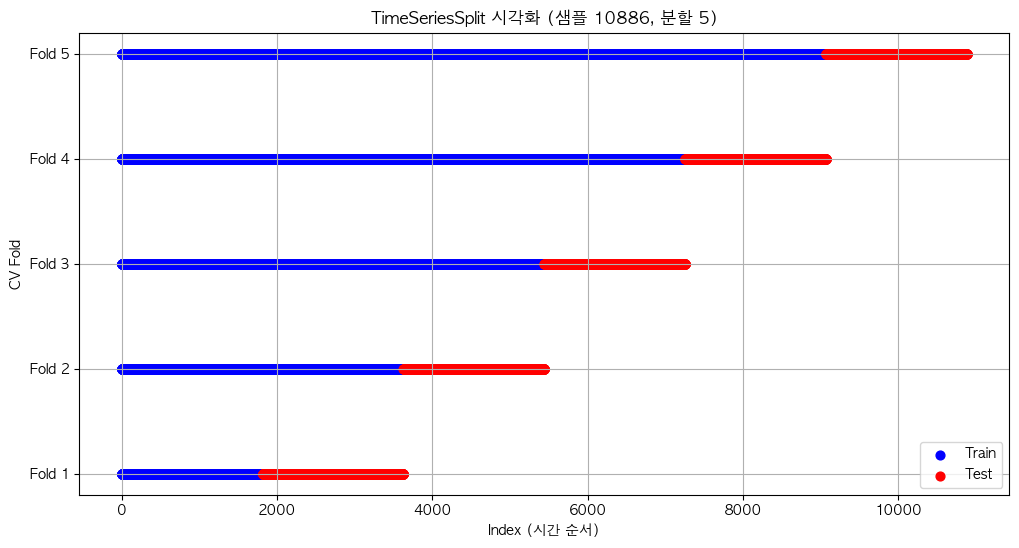

In [7]:
# 실제 데이터에 적용할 경우
plot_timeseries_split(n_samples=X_all_ts.shape[0], n_splits=5)

### 2-3. 앙상블 모델링 (가중 평균)
- 선형회귀와 랜덤포레스트의 검증 예측을 가중 평균
- 검증 성능으로 가중치 선택 후 테스트 평가


[Metrics]
MAE  : 59.311357 - 평균 절대 오차
MSE  : 8326.449294 - 평균 제곱 오차
RMSE : 91.249380 - 제곱근 평균 제곱 오차
R^2  : 0.850787 - 결정계수(설명된 분산 비율)
[Metrics]
MAE  : 60.226095 - 평균 절대 오차
MSE  : 8501.793626 - 평균 제곱 오차
RMSE : 92.205171 - 제곱근 평균 제곱 오차
R^2  : 0.847645 - 결정계수(설명된 분산 비율)
[Metrics]
MAE  : 61.818753 - 평균 절대 오차
MSE  : 8729.076045 - 평균 제곱 오차
RMSE : 93.429524 - 제곱근 평균 제곱 오차
R^2  : 0.843572 - 결정계수(설명된 분산 비율)
[Metrics]
MAE  : 63.734434 - 평균 절대 오차
MSE  : 9008.296552 - 평균 제곱 오차
RMSE : 94.912046 - 제곱근 평균 제곱 오차
R^2  : 0.838568 - 결정계수(설명된 분산 비율)
[Metrics]
MAE  : 65.902910 - 평균 절대 오차
MSE  : 9339.455145 - 평균 제곱 오차
RMSE : 96.640856 - 제곱근 평균 제곱 오차
R^2  : 0.832634 - 결정계수(설명된 분산 비율)
[Metrics]
MAE  : 68.222106 - 평균 절대 오차
MSE  : 9722.551825 - 평균 제곱 오차
RMSE : 98.603001 - 제곱근 평균 제곱 오차
R^2  : 0.825769 - 결정계수(설명된 분산 비율)
[Metrics]
MAE  : 70.632934 - 평균 절대 오차
MSE  : 10157.586592 - 평균 제곱 오차
RMSE : 100.784853 - 제곱근 평균 제곱 오차
R^2  : 0.817973 - 결정계수(설명된 분산 비율)
[Metrics]
MAE  : 73.163485 - 평균 절대 오차
MSE  : 10644.559446 - 

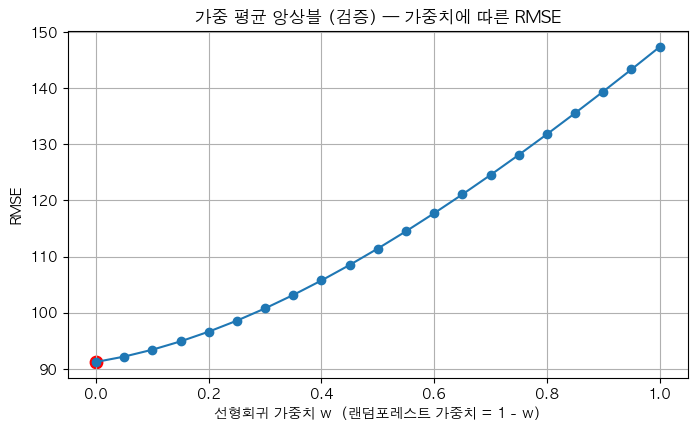


[검증 결과 상위 5개 (RMSE 기준)]
 w(linear)  w(rf)  linear%  rf%    MAE   RMSE    R2
     0.000  1.000        0  100 59.311 91.249 0.851
     0.050  0.950        5   95 60.226 92.205 0.848
     0.100  0.900       10   90 61.819 93.430 0.844
     0.150  0.850       15   85 63.734 94.912 0.839
     0.200  0.800       20   80 65.903 96.641 0.833
[Metrics]
MAE  : 68.762976 - 평균 절대 오차
MSE  : 10117.330518 - 평균 제곱 오차
RMSE : 100.584942 - 제곱근 평균 제곱 오차
R^2  : 0.731398 - 결정계수(설명된 분산 비율)

[요약]
- 최적 가중치 w = 0.00  (선형회귀 0%, 랜덤포레스트 100%)
- 검증 RMSE = 91.249
- 테스트 성능 → MAE=68.763, RMSE=100.585, R^2=0.731


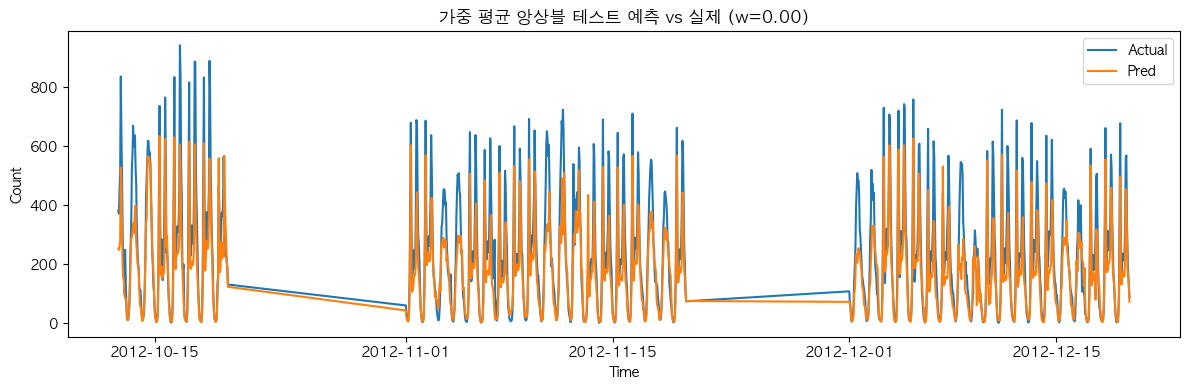

In [8]:
def weighted_ensemble(y1, y2, w):
    """
    두 모델의 예측값을 가중 평균하여 앙상블
    
    Parameters
    ----------
    y1 : array-like
        첫 번째 모델의 예측값 (예: 선형회귀)
    y2 : array-like
        두 번째 모델의 예측값 (예: 랜덤포레스트)
    w : float
        첫 번째 모델의 가중치 (0~1 사이 값)
        두 번째 모델의 가중치는 자동으로 (1 - w)
    
    Returns
    -------
    array-like
        가중 평균된 예측값
    """
    return w*y1 + (1-w)*y2


def search_weight_and_report(lin_val_pred, rf_val_pred, y_val,
                             lin_test_pred, rf_test_pred, y_test,
                             weights=np.linspace(0, 1, 21),
                             title_prefix='앙상블'):
    """
    다양한 가중치 조합으로 검증 성능을 평가하고,
    최적 가중치를 찾아 테스트셋 성능까지 보고하는 함수.
    
    Parameters
    ----------
    lin_val_pred, rf_val_pred : array-like
        검증셋에서 선형회귀/랜덤포레스트 예측값
    y_val : Series or array-like
        검증셋 실제값
    lin_test_pred, rf_test_pred : array-like
        테스트셋에서 선형회귀/랜덤포레스트 예측값
    y_test : Series or array-like
        테스트셋 실제값
    weights : array-like
        탐색할 가중치 후보 리스트 (0~1)
    title_prefix : str
        시각화 및 출력 제목 prefix
    """
    rows = []
    best_w, best_rmse = None, float('inf')

    # -----------------------------
    # 1) 검증 데이터에서 가중치별 성능 측정
    # -----------------------------
    for w in weights:
        # 현재 가중치 조합으로 앙상블 예측
        ens_val = weighted_ensemble(lin_val_pred, rf_val_pred, w)
        
        # 성능 지표 계산
        mae, mse, rmse, r2 = compute_metrics(y_val.to_numpy(), ens_val)
        
        # 기록 저장
        rows.append({
            'weight_linear': float(w),
            'weight_rf': float(1-w),
            'MAE': mae, 'MSE': mse, 'RMSE': rmse, 'R2': r2
        })
        
        # 최적 가중치 갱신 (RMSE 최소 기준)
        if rmse < best_rmse:
            best_rmse = rmse
            best_w = w

    # -----------------------------
    # 2) DataFrame 정리
    # -----------------------------
    df = pd.DataFrame(rows)
    df_sorted = df.sort_values('weight_linear').reset_index(drop=True)

    # -----------------------------
    # 3) 가중치 vs RMSE 곡선 시각화
    # -----------------------------
    plt.figure(figsize=(8,4.5))
    plt.plot(df_sorted['weight_linear'], df_sorted['RMSE'], marker='o')
    
    # 최적 지점 표시
    plt.scatter([best_w], [best_rmse], s=80, color="red")
    plt.title(f'{title_prefix} (검증) — 가중치에 따른 RMSE')
    plt.xlabel('선형회귀 가중치 w  (랜덤포레스트 가중치 = 1 - w)')
    plt.ylabel('RMSE')
    plt.grid(True)
    plt.show()

    # -----------------------------
    # 4) 검증 결과 상위 5개 (RMSE 기준)
    # -----------------------------
    topk = df.nsmallest(5, 'RMSE').copy()
    topk['linear%'] = (topk['weight_linear']*100).round(0).astype(int)
    topk['rf%'] = (topk['weight_rf']*100).round(0).astype(int)
    
    print('\n[검증 결과 상위 5개 (RMSE 기준)]')
    print(
        topk[['weight_linear', 'weight_rf', 'linear%', 'rf%', 'MAE', 'RMSE', 'R2']]
        .rename(columns={'weight_linear':'w(linear)','weight_rf':'w(rf)'})
        .to_string(index=False, float_format=lambda x: f'{x:,.3f}')
    )

    # -----------------------------
    # 5) 최적 가중치로 테스트셋 성능 평가
    # -----------------------------
    ens_test = weighted_ensemble(lin_test_pred, rf_test_pred, best_w)
    mae_t, mse_t, rmse_t, r2_t = compute_metrics(y_test.to_numpy(), ens_test)

    print('\n[요약]')
    print(f"- 최적 가중치 w = {best_w:.2f}  "
          f"(선형회귀 {best_w*100:.0f}%, 랜덤포레스트 {(1-best_w)*100:.0f}%)")
    print(f"- 검증 RMSE = {best_rmse:.3f}")
    print(f"- 테스트 성능 → MAE={mae_t:.3f}, RMSE={rmse_t:.3f}, R^2={r2_t:.3f}")

    # -----------------------------
    # 6) 테스트셋 실제값 vs 앙상블 예측값 시각화
    # -----------------------------
    try:
        plot_actual_vs_pred(
            test_df['datetime'].values,   # 기존 코드의 test_df 활용
            y_test.to_numpy(),
            ens_test,
            f'{title_prefix} 테스트 예측 vs 실제 (w={best_w:.2f})'
        )
    except NameError:
        # test_df가 외부에서 정의되지 않았을 경우 대비
        pass

    return best_w, df_sorted


# ---------------------------
# 사용 예시
# ---------------------------
best_w, df_weights = search_weight_and_report(
    lin_val_pred, rf_val_pred, y_val,
    lin_test_pred, rf_test_pred, y_test,
    weights=np.linspace(0, 1, 21),  # 0.00 ~ 1.00 (0.05 간격)
    title_prefix='가중 평균 앙상블'
)




### 2-4. 잔차 분석
- 테스트 구간 잔차 시각화 및 분포 확인
- 패턴/이분산/비정상성 여부 점검


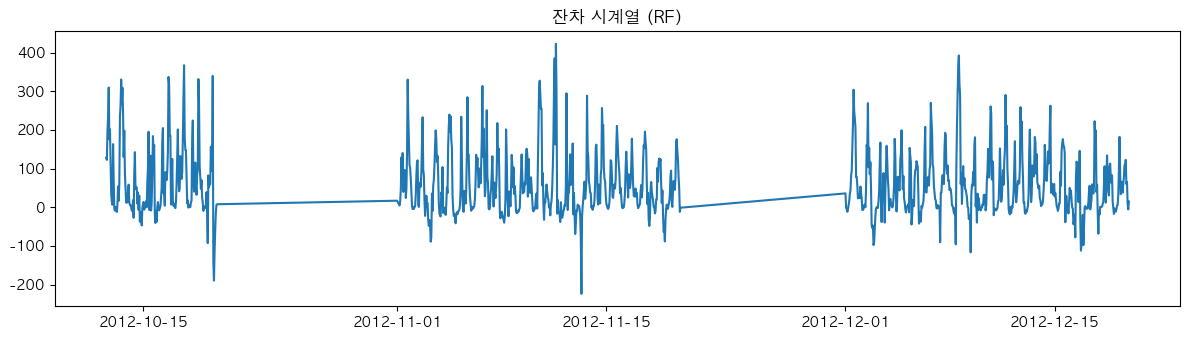

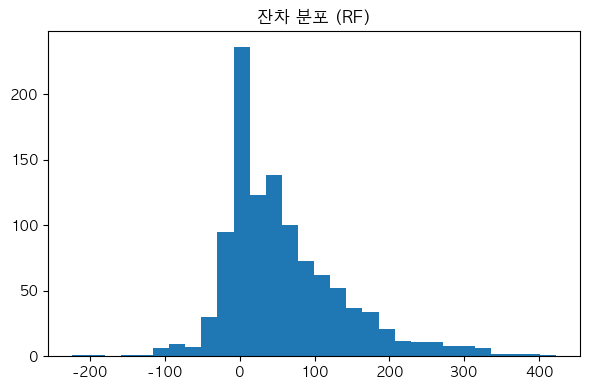

In [9]:
# -----------------------------
# 1) 잔차 계산
# -----------------------------
# 실제값 - 예측값 = 잔차(residual)
residual = y_test.to_numpy() - rf_test_pred


# -----------------------------
# 2) 잔차 시계열 플롯
# -----------------------------
plt.figure(figsize=(12,3.5))
plt.plot(test_df['datetime'].values, residual)   # x축: 시간(datetime), y축: 잔차
plt.title('잔차 시계열 (RF)')                   # 제목
plt.tight_layout()
plt.show()

# 해석: 시간에 따라 잔차가 일정 패턴을 보이는지 확인
#       (랜덤한 분포라면 모델이 시계열 구조를 잘 설명하고 있다는 의미)


# -----------------------------
# 3) 잔차 분포 히스토그램
# -----------------------------
plt.figure(figsize=(6,4))
plt.hist(residual, bins=30)                     # 구간을 30개로 나눠 분포 확인
plt.title('잔차 분포 (RF)')
plt.tight_layout()
plt.show()

# 해석: 잔차가 정규분포에 가까운 종 모양(Bell-shape)이면 모델 적합이 양호함
#       한쪽으로 치우쳐 있거나 긴 꼬리가 있으면 편향(bias) 또는 과대/과소 예측 가능성 있음



### 2-5. 잔차 분석 결과 해석 (Random Forest)

#### 1). 잔차 시계열 (Residual Time Series)
- 시간 축에 따라 예측 오차(실제값 - 예측값)를 표시한 그래프  
- **특징**:
  - 대부분 잔차가 0 근처에 분포하지만, 구간별로 뭉침 현상이 보임
  - 일부 시점에서 큰 양수(과소예측) 또는 음수(과대예측) 피크 발생
  - 완전히 무작위(white noise) 형태가 아니며, 시간에 따른 구조적 패턴이 남아 있음  

 **해석**:  
모델이 평균적으로는 잘 맞추지만, **특정 시점(급등/급락 구간 등)**에서는 예측력이 떨어지며,  
이는 모델이 **계절성/추세 같은 일부 패턴을 충분히 반영하지 못했음을 시사**함.

---

#### 2) 잔차 분포 (Residual Histogram)
- 잔차 값의 빈도 분포를 나타낸 그래프  
- **특징**:
  - 중심이 0 근처에 있으며, 대체로 좌우 대칭에 가까운 형태
  - 다만 오른쪽 꼬리(양의 잔차)가 조금 더 길어 실제보다 작게 예측하는 경향이 일부 존재
  - 대부분 잔차는 -100 ~ +200 구간에 분포, 소수의 극단값(±200~400) 존재  

 **해석**:  
잔차 분포는 대체로 정규분포에 가까워 **큰 편향은 없지만**,  
약간의 오른쪽 비대칭성으로 인해 **과소예측 경향**이 확인됨.  
또한 일부 **이상치(Outlier)** 오차가 존재하여 개선 여지가 있음.

---

#### 종합 결론
- RF(RandomForest) 모델은 전반적으로 성능이 양호하나,  
  1. 잔차 시계열에서 **시간 구조적 패턴**이 남아 있음  
  2. 잔차 분포에서 **과소예측 경향 및 이상치**가 확인됨  

 **개선 방향**:
- 시계열 특성을 반영한 피처 추가 (요일, 주기성, Lag, Rolling Mean 등)
- 다른 알고리즘(XGBoost, LightGBM, LSTM 등) 비교 적용
- 잔차 기반 추가 피처 엔지니어링 진행


### 3-1. 시계열 전용 모델: SARIMA, Prophet(선택)
- 일 단위 평균으로 집계 후 예측
- SARIMA 기본 파라미터로 시연, Prophet은 설치 시 실행


[Metrics]
MAE  : 36.915106 - 평균 절대 오차
MSE  : 2645.839036 - 평균 제곱 오차
RMSE : 51.437720 - 제곱근 평균 제곱 오차
R^2  : -0.276301 - 결정계수(설명된 분산 비율)
SARIMA/VAL (36.915105848758586, 2645.8390363580256, 51.43771997627836, -0.2763014988133232)
[Metrics]
MAE  : 49.686400 - 평균 절대 오차
MSE  : 3041.212785 - 평균 제곱 오차
RMSE : 55.147192 - 제곱근 평균 제곱 오차
R^2  : -1.677988 - 결정계수(설명된 분산 비율)
SARIMA/TEST (49.686400457179325, 3041.212784723112, 55.147191993093465, -1.677987591640588)


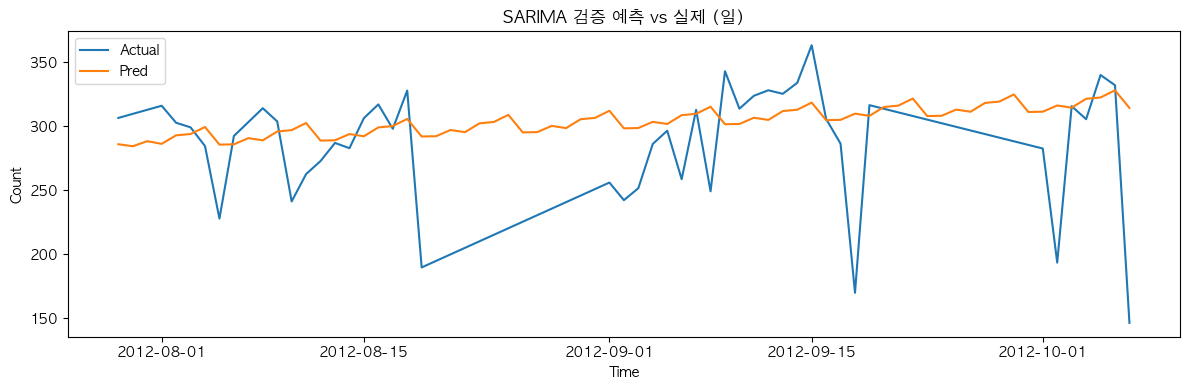

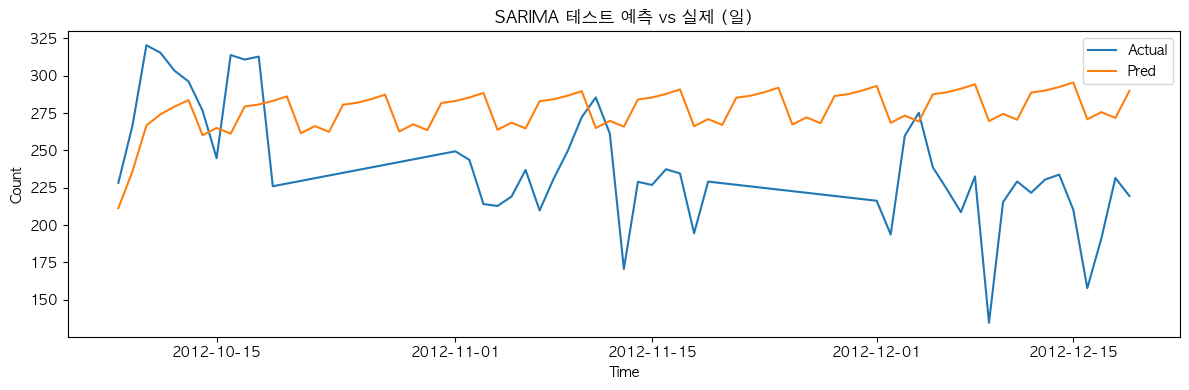

15:10:42 - cmdstanpy - INFO - Chain [1] start processing
15:10:42 - cmdstanpy - INFO - Chain [1] done processing


[Metrics]
MAE  : 55.136594 - 평균 절대 오차
MSE  : 5054.311634 - 평균 제곱 오차
RMSE : 71.093682 - 제곱근 평균 제곱 오차
R^2  : -1.438102 - 결정계수(설명된 분산 비율)
Prophet/VAL (55.136593561391784, 5054.311634076586, 71.09368209676994, -1.4381020256323187)


In [10]:
def aggregate_daily(df: pd.DataFrame) -> pd.Series:
    """
    시간 단위 데이터를 일 단위로 집계하는 함수
    - datetime을 인덱스로 설정
    - count 컬럼을 일별 평균으로 집계
    """
    return df.set_index('datetime')['count'].resample('D').mean()


# -----------------------------
# 1) 일 단위 데이터 준비
# -----------------------------
daily = aggregate_daily(df)

# 빈 날짜 채우기 + 보간 처리
daily = (
    daily.asfreq('D')        # 모든 날짜를 연속적으로 채움 (결측치 발생)
         .interpolate()      # 선형 보간 (연속된 값 보정)
         .ffill().bfill()    # 앞/뒤 값 보간으로 잔여 결측치 보정
)

# train/val/test 분할 (80% / 10% / 10%)
N = len(daily)
N_tr, N_va = int(N*0.8), int(N*0.1)
daily_tr = daily.iloc[:N_tr]
daily_va = daily.iloc[N_tr:N_tr+N_va]
daily_te = daily.iloc[N_tr+N_va:]


# -----------------------------
# 2) SARIMA 모델 학습 & 예측
# -----------------------------
# (1,1,1) ARIMA + (1,1,1,7) 주간 계절성 고려
sar = SARIMAX(
    daily_tr,
    order=(1,1,1),
    seasonal_order=(1,1,1,7),
    enforce_stationarity=False,
    enforce_invertibility=False
).fit(disp=False)

# 검증 구간 예측
va_fc = sar.forecast(steps=len(daily_va)).to_numpy()

# 학습+검증 데이터 전체를 활용하여 test 구간 예측
combined = pd.concat([daily_tr, daily_va])
te_fc = (
    SARIMAX(
        combined,
        order=(1,1,1),
        seasonal_order=(1,1,1,7),
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    .fit(disp=False)
    .forecast(steps=len(daily_te))
    .to_numpy()
)

# 성능 평가 출력
print('SARIMA/VAL', compute_metrics(daily_va.to_numpy(), va_fc))
print('SARIMA/TEST', compute_metrics(daily_te.to_numpy(), te_fc))

# 실제 vs 예측 시각화
plot_actual_vs_pred(daily_va.index, daily_va.to_numpy(), va_fc, 'SARIMA 검증 예측 vs 실제 (일)')
plot_actual_vs_pred(daily_te.index, daily_te.to_numpy(), te_fc, 'SARIMA 테스트 예측 vs 실제 (일)')


# -----------------------------
# 3) Prophet 모델 학습 & 예측 (설치 여부 확인)
# -----------------------------
if _HAS_PROPHET:
    # Prophet은 ds, y 컬럼 필요
    dprop = pd.DataFrame({'ds': daily_tr.index, 'y': daily_tr.values})
    
    # Prophet 모델 생성 (주간 seasonality만 사용)
    m = Prophet(
        seasonality_mode='additive',
        weekly_seasonality=True,
        daily_seasonality=False,
        yearly_seasonality=False
    )
    m.fit(dprop)
    
    # 검증 구간 길이만큼 미래 데이터프레임 생성
    future = pd.DataFrame({
        'ds': pd.date_range(
            start=daily_tr.index[-1] + pd.Timedelta(days=1),
            periods=len(daily_va),
            freq='D'
        )
    })
    
    # 예측 수행
    yhat_val = m.predict(future)['yhat'].to_numpy()
    
    # 성능 평가
    print('Prophet/VAL', compute_metrics(daily_va.to_numpy(), yhat_val))

else:
    print('Prophet 미설치: 건너뜀')



### 3-2. 왜 SARIMA와 Prophet은 성능이 낮을까?

#### 1) 데이터 특성과의 부적합성
- SARIMA/Prophet은 **추세 + 계절성** 패턴이 뚜렷하고 비교적 안정적인 시계열 데이터에 강점이 있음.  
- 하지만 자전거 대여 데이터는 다음과 같은 특성이 존재:
  - **외부 요인**(기온, 습도, 날씨, 요일, 근무일 여부, 시간대 등)에 크게 의존  
  - 날씨 변화나 휴일 이벤트 등으로 **급격한 수요 변동(스파이크)** 발생  
- 따라서 단순히 과거 시계열 패턴만 보는 SARIMA/Prophet은 이를 제대로 반영하지 못함.  

---

#### 2) 모델의 구조적 한계
##### SARIMA
- 자기회귀(AR) + 차분(I) + 이동평균(MA) + 계절성(S)을 기반으로 작동.  
- **단일/고정된 계절성**에는 잘 맞지만, 자전거 대여 데이터처럼 **하루 주기 + 주간 주기 + 날씨 영향**이 동시에 존재하는 경우 한계가 있음.  
- 특히 시간대별 변동성이 큰 패턴을 포착하기 어려움.  

##### Prophet
- 구조: **트렌드 + 주간/연간 계절성 + 휴일 효과**  
- 장점: 휴일 효과 반영, 비선형 트렌드 처리  
- 단점: **단기 변동성**과 **비선형 외부 변수 효과**(예: 특정 기온 구간에서 수요 급증)를 반영하기 어려움.  
- 이번 데이터에서 중요한 기상·시간 요인을 직접 반영할 수 없었음.  

---

#### 3) 데이터 전처리/분해 한계
- 실제 데이터에는 결측치, 이상치, 극단적 이벤트(폭우, 폭설 등)가 포함되어 있음.  
- SARIMA/Prophet은 이런 이상 변동을 **추세/계절성으로 잘못 흡수**하여 오차가 커짐.  

---

#### 4) 다른 모델과의 비교
- **Linear Regression, RandomForest** 등 머신러닝 모델은 **외부 피처**를 직접 활용 가능:
  - 기온이 높을 때 수요 증가  
  - 퇴근 시간대(17~19시) 수요 폭증  
- 따라서 비선형·복합적인 요인을 학습하여 성능이 향상됨.  
- 반면 SARIMA/Prophet은 **외부 요인 없이 오직 과거 수요 데이터만** 사용 → 성능이 낮게 나타남.  

---

#### 결론
- SARIMA/Prophet의 낮은 성능 이유:
  1. **외부 요인(날씨·요일·시간대)을 반영하지 못함**  
  2. **급격한 수요 변동(스파이크)에 취약**  
  3. **다중 계절성과 비선형 구조를 충분히 설명하지 못함**  

이 데이터에서는 **랜덤포레스트 같은 피처 기반 머신러닝 모델**이 훨씬 더 적합하며,  
추가로 Gradient Boosting 계열(XGBoost, LightGBM)이나 시계열 특화 딥러닝(LSTM 등)을 고려할 수 있음.


### 4-1. 시퀀스 데이터셋 생성 및 LSTM 모델 정의
- 윈도우 크기 24(하루)로 시퀀스 구성, horizon=1
- 단순 LSTM 회귀 헤드

In [11]:
import torch
from torch import nn
from torch.utils.data import DataLoader

def _set_seed(seed: int = 42) -> None:
    """
    랜덤 시드를 고정하여 재현성(reproducibility)을 확보하는 함수
    
    Parameters
    ----------
    seed : int, default=42
        난수 시드 값 (고정할 숫자)
    
    설명
    ----
    - np.random.seed(seed): NumPy 난수 시드 고정
    - torch.manual_seed(seed): CPU 연산용 PyTorch 난수 시드 고정
    - torch.cuda.manual_seed_all(seed): GPU 연산용 PyTorch 난수 시드 고정
      (멀티 GPU 환경에서도 동일한 시드가 적용됨)
    """
    # NumPy 난수 시드 고정
    np.random.seed(seed)
    
    # PyTorch CPU 난수 시드 고정
    torch.manual_seed(seed)
    
    # PyTorch GPU 난수 시드 고정 (모든 GPU에 적용)
    torch.cuda.manual_seed_all(seed)


In [12]:
def build_feature_matrix(df: pd.DataFrame):
    """
    DataFrame에서 모델 학습에 사용할 특징 행렬(X)과 타깃 벡터(y)를 생성하는 함수
    
    Parameters
    ----------
    df : pd.DataFrame
        입력 데이터 (datetime 포함, bike sharing demand 데이터셋)
    
    Returns
    -------
    X : np.ndarray (shape = [n_samples, n_features])
        특징 행렬 (float32 타입)
    y : np.ndarray (shape = [n_samples])
        타깃 벡터 (count, float32 타입)
    feature_cols : list of str
        사용된 특징 변수들의 이름 리스트
    """
    # 사용할 피처 컬럼 정의
    feature_cols = [
        'temp','atemp','humidity','windspeed',  # 기상 관련
        'season','holiday','workingday','weather',  # 카테고리/상황 변수
        'year','month','dayofweek','hour'      # 시간 관련 파생 변수
    ]
    
    # X: 특징 행렬 (NumPy 배열, float32로 변환 → PyTorch/TF 학습 호환)
    X = df[feature_cols].to_numpy(dtype=np.float32)
    
    # y: 타깃 벡터 (대여 수요 count, float32로 변환)
    y = df['count'].astype(np.float32).to_numpy()
    
    return X, y, feature_cols



In [13]:
def make_windows(X: np.ndarray, y: np.ndarray, window: int, horizon: int = 1):
    """
    시계열 데이터를 (입력 시퀀스, 예측 대상 시퀀스) 윈도우 형태로 변환
    
    Parameters
    ----------
    X : np.ndarray, shape = [n_samples, n_features]
        입력 특징 데이터 (시간 순서대로 정렬된 상태)
    y : np.ndarray, shape = [n_samples]
        타깃 벡터 (예: count)
    window : int
        입력 시퀀스의 길이 (과거 관측치 개수)
    horizon : int, default=1
        예측할 미래 시점의 개수 (1이면 다음 시점만 예측)
    
    Returns
    -------
    xs : np.ndarray, shape = [n_windows, window, n_features]
        모델 입력 (과거 window 길이만큼의 시퀀스)
    ys : np.ndarray, shape = [n_windows, horizon]
        모델 출력 (horizon 길이만큼의 미래 값)
    
    예시
    ----
    X = [[x1], [x2], [x3], [x4], [x5]], y = [y1, y2, y3, y4, y5]
    window=2, horizon=1 → 
        xs = [[[x1],[x2]], [[x2],[x3]], [[x3],[x4]]]
        ys = [[y3], [y4], [y5]]
    """
    xs, ys = [], []
    
    # i 위치부터 window 길이 만큼 X를 입력으로 사용하고,
    # 그 다음 horizon 길이 만큼 y를 예측 대상으로 설정
    for i in range(len(X) - window - horizon + 1):
        xs.append(X[i:i+window])                    # 입력 구간 (window 길이)
        ys.append(y[i+window:i+window+horizon])     # 출력 구간 (horizon 길이)
    
    # 리스트를 NumPy 배열로 변환 (float32 → PyTorch 호환)
    return np.asarray(xs, dtype=np.float32), np.asarray(ys, dtype=np.float32)


### 4-2. 학습/검증/테스트
- 표준화: train 기준 평균/표준편차
- 학습: Adam + MSE, 베스트 모델 선택
- 예측 vs 실제 시각화


In [14]:
# -----------------------------------------
# LSTM + Linear head 조합을 쉽게 생성하는 헬퍼
# -----------------------------------------
def make_lstm_pair(input_size: int, hidden_size: int = 64, num_layers: int = 2, dropout: float = 0.1, device=None):
    """
    LSTM + Linear 조합 모델을 간단히 생성하는 함수
    
    Parameters
    ----------
    input_size : int
        입력 특징(feature) 개수
    hidden_size : int, default=64
        LSTM 은닉 상태(hidden state) 차원 크기
    num_layers : int, default=2
        LSTM 레이어(층) 개수 (스택 구조)
    dropout : float, default=0.1
        LSTM 레이어 사이에 적용할 드롭아웃 비율
    device : torch.device or None
        모델을 올릴 장치 (None이면 GPU 사용 가능 여부에 따라 자동 선택)
    
    Returns
    -------
    lstm : nn.LSTM
        시계열 특징 추출용 LSTM 네트워크
    head : nn.Linear
        마지막 hidden state를 받아 최종 예측을 출력하는 Linear 레이어
    device : torch.device
        모델이 올라간 장치 정보
    """
    # 학습 장치 선택 (GPU 사용 가능하면 cuda, 아니면 cpu)
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # LSTM 정의
    lstm = nn.LSTM(
        input_size=input_size,   # 입력 특징 차원
        hidden_size=hidden_size, # 은닉 상태 차원
        num_layers=num_layers,   # LSTM 층 개수
        batch_first=True,        # 입력 shape = (batch, seq_len, input_size)
        dropout=dropout          # 레이어 사이 dropout 적용
    ).to(device)
    
    # LSTM의 마지막 hidden state → 최종 1차원 출력값으로 매핑
    head = nn.Linear(hidden_size, 1).to(device)
    
    return lstm, head, device


# -----------------------------------------
# LSTM forward 함수
# -----------------------------------------
def lstm_forward(lstm: nn.LSTM, head: nn.Linear, x: torch.Tensor) -> torch.Tensor:
    """
    LSTM + Linear head 조합의 forward 패스
    
    Parameters
    ----------
    lstm : nn.LSTM
        LSTM 네트워크
    head : nn.Linear
        최종 출력 레이어
    x : torch.Tensor, shape = (batch, seq_len, input_size)
        입력 시퀀스
    
    Returns
    -------
    torch.Tensor, shape = (batch,)
        예측된 출력값 (마지막 시점 기준)
    """
    # LSTM 통과 → out: (batch, seq_len, hidden_size)
    out, _ = lstm(x)
    
    # 마지막 시점의 hidden state 선택 (seq_len의 마지막 위치)
    last = out[:, -1, :]   # shape = (batch, hidden_size)
    
    # Linear head 통과 → 최종 출력
    return head(last).squeeze(-1)   # shape = (batch,)


Epoch 001 - train MSE: 7.5473, val MSE: 0.9787
Epoch 002 - train MSE: 0.9544, val MSE: 0.3306
Epoch 003 - train MSE: 0.8853, val MSE: 0.2331
Epoch 004 - train MSE: 0.5703, val MSE: 0.2056
Epoch 005 - train MSE: 0.4702, val MSE: 0.2018
Epoch 006 - train MSE: 0.3617, val MSE: 0.1855
Epoch 007 - train MSE: 0.3484, val MSE: 0.1793
Epoch 008 - train MSE: 0.3090, val MSE: 0.1827
Epoch 009 - train MSE: 0.3078, val MSE: 0.1817
Epoch 010 - train MSE: 0.2866, val MSE: 0.1805
Epoch 011 - train MSE: 0.2523, val MSE: 0.1599
Epoch 012 - train MSE: 0.2387, val MSE: 0.1434
Epoch 013 - train MSE: 0.2169, val MSE: 0.1294
Epoch 014 - train MSE: 0.2033, val MSE: 0.1191
Epoch 015 - train MSE: 0.1897, val MSE: 0.1123
Epoch 016 - train MSE: 0.1816, val MSE: 0.1157
Epoch 017 - train MSE: 0.1843, val MSE: 0.1237
Epoch 018 - train MSE: 0.1663, val MSE: 0.1136
Epoch 019 - train MSE: 0.1604, val MSE: 0.1085
Epoch 020 - train MSE: 0.1585, val MSE: 0.1081


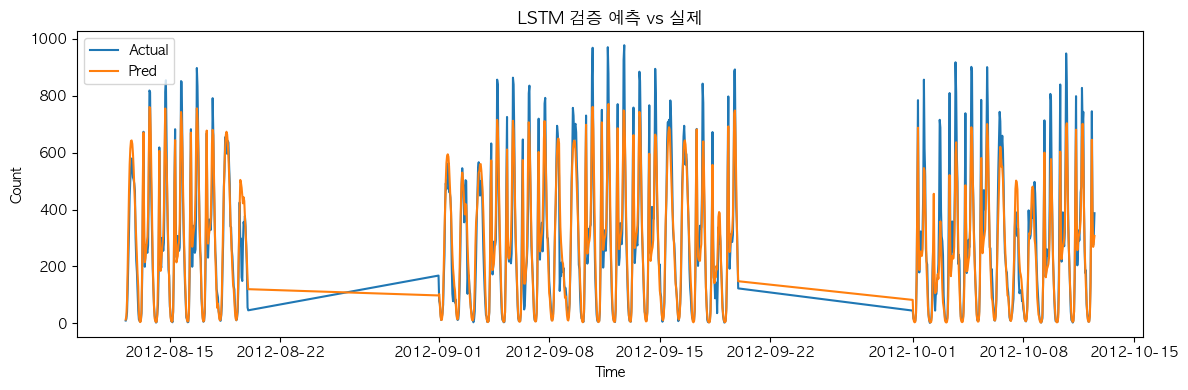

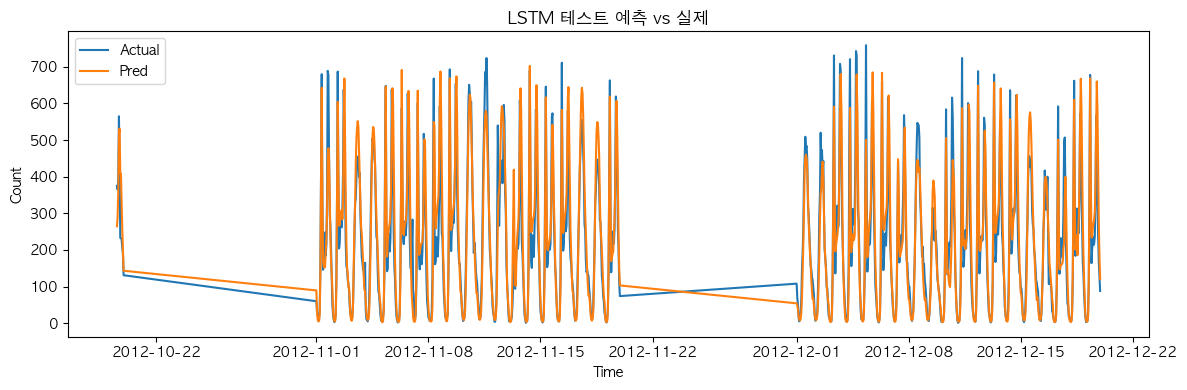

In [15]:
# -----------------------------
# 학습 루프 (클래스 버전이 아닌 함수 버전)
# -----------------------------
def train_model(model, train_loader, val_loader, epochs: int, lr: float, device):
    """
    일반 nn.Module 기반 모델 학습 함수
    - MSELoss, Adam, ReduceLROnPlateau, EarlyStopping 포함
    """
    criterion = nn.MSELoss()
    optim = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, factor=0.5, patience=3)
    
    patience = 8           # 조기 종료 patience
    no_improve = 0         # 개선 없는 epoch 카운터
    best_val = float('inf')
    best_state = None
    
    for ep in range(1, epochs+1):
        # ----- 학습 단계 -----
        model.train()
        tr_sum, n = 0.0, 0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            pred = model(xb)
            loss = criterion(pred, yb)
            
            optim.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # gradient clipping
            optim.step()
            
            tr_sum += float(loss.item()) * len(xb)
            n += len(xb)
        tr_loss = tr_sum / max(n, 1)

        # ----- 검증 단계 -----
        model.eval()
        with torch.no_grad():
            va_sum, n2 = 0.0, 0
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                pred = model(xb)
                loss = criterion(pred, yb)
                va_sum += float(loss.item()) * len(xb)
                n2 += len(xb)
        va_loss = va_sum / max(n2, 1)
        
        # 로그 출력
        print(f'Epoch {ep:03d} - train MSE: {tr_loss:.4f}, val MSE: {va_loss:.4f}')
        
        # LR scheduler
        scheduler.step(va_loss)
        
        # Early stopping 체크
        if va_loss + 1e-9 < best_val:
            no_improve = 0
        else:
            no_improve += 1
            if no_improve >= patience:
                print(f'[EarlyStop] epoch={ep} val={va_loss:.5f}')
                break
        
        # Best 모델 저장
        if va_loss < best_val:
            best_val = va_loss
            best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
    
    # 학습 종료 후 best 가중치 복원
    if best_state is not None:
        model.load_state_dict(best_state)


# -----------------------------
# 예측 함수
# -----------------------------
def predict_all(model, loader, device):
    """
    전체 DataLoader에 대해 예측 수행 후 numpy 배열 반환
    """
    model.eval()
    outs = []
    with torch.no_grad():
        for xb, _ in loader:
            xb = xb.to(device)
            pred = model(xb)
            outs.append(pred.cpu().numpy())
    return np.concatenate(outs, axis=0)


# -----------------------------
# 시각화 함수
# -----------------------------
def plot_series(dt_index, y_true, y_pred, title):
    """
    시계열 실제값 vs 예측값 그래프
    """
    plt.figure(figsize=(12,4))
    plt.plot(dt_index, y_true, label='Actual')
    plt.plot(dt_index, y_pred, label='Pred')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Count')
    plt.legend()
    plt.tight_layout()
    plt.show()


# -----------------------------
# 데이터 구성 단계
# -----------------------------
# 개선 3가지:
# (1) 주간 창(window=168)
# (2) 시간 원형 인코딩(hour_sin, hour_cos)
# (3) 로그 변환 타깃
def add_cyclical_cols(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()
    out['hour_sin'] = np.sin(2*np.pi*out['hour']/24)  # 주기성 보존
    out['hour_cos'] = np.cos(2*np.pi*out['hour']/24)
    return out

# 시간 원형 인코딩 추가
train_df = add_cyclical_cols(train_df)
val_df   = add_cyclical_cols(val_df)
test_df  = add_cyclical_cols(test_df)

# X, y 생성
X_train, y_train, feat_cols = build_feature_matrix(train_df)
X_val,   y_val,   _         = build_feature_matrix(val_df)
X_test,  y_test,  _         = build_feature_matrix(test_df)

# X에 hour_sin/cos 이어붙이기
def append_cols(X: np.ndarray, df: pd.DataFrame, cols: list[str]) -> np.ndarray:
    return np.concatenate([X, df[cols].to_numpy(dtype=np.float32)], axis=1)

X_train = append_cols(X_train, train_df, ['hour_sin','hour_cos'])
X_val   = append_cols(X_val,   val_df,   ['hour_sin','hour_cos'])
X_test  = append_cols(X_test,  test_df,  ['hour_sin','hour_cos'])

# 표준화 (train 기준)
mean, std = X_train.mean(axis=0, keepdims=True), X_train.std(axis=0, keepdims=True) + 1e-8
X_train, X_val, X_test = (X_train-mean)/std, (X_val-mean)/std, (X_test-mean)/std

# 로그 타깃 적용 (정규성 개선)
use_log_target = True
if use_log_target:
    y_train, y_val, y_test = np.log1p(y_train), np.log1p(y_val), np.log1p(y_test)

# -----------------------------
# 시퀀스 데이터 생성 (LSTM 입력용)
# -----------------------------
window = 168  # 1주일 = 24*7
Xtr_seq, ytr_seq = make_windows(X_train, y_train, window)
Xva_seq, yva_seq = make_windows(X_val,   y_val,   window)
Xte_seq, yte_seq = make_windows(X_test,  y_test,  window)

# 타깃 차원 정리
ytr_1d = ytr_seq.squeeze(-1) if ytr_seq.ndim > 1 else ytr_seq
yva_1d = yva_seq.squeeze(-1) if yva_seq.ndim > 1 else yva_seq
yte_1d = yte_seq.squeeze(-1) if yte_seq.ndim > 1 else yte_seq

# Tensor 변환
a2_Xtr, a2_ytr = torch.as_tensor(Xtr_seq, dtype=torch.float32), torch.as_tensor(ytr_1d, dtype=torch.float32)
a2_Xva, a2_yva = torch.as_tensor(Xva_seq, dtype=torch.float32), torch.as_tensor(yva_1d, dtype=torch.float32)
a2_Xte, a2_yte = torch.as_tensor(Xte_seq, dtype=torch.float32), torch.as_tensor(yte_1d, dtype=torch.float32)

# (x, y) 튜플 리스트로 묶기
train_data, val_data, test_data = list(zip(a2_Xtr, a2_ytr)), list(zip(a2_Xva, a2_yva)), list(zip(a2_Xte, a2_yte))

# DataLoader 구성
train_loader = DataLoader(train_data, batch_size=128, shuffle=False, drop_last=True)
val_loader   = DataLoader(val_data,   batch_size=256, shuffle=False)
test_loader  = DataLoader(test_data,  batch_size=256, shuffle=False)


# -----------------------------
# LSTM + Linear 학습
# -----------------------------
_set_seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# LSTM + Linear 생성
input_size = Xtr_seq.shape[-1]
lstm_nc, head_nc, _ = make_lstm_pair(input_size=input_size, hidden_size=64, num_layers=2, dropout=0.1, device=device)

# 최적화 세팅
params_nc = list(lstm_nc.parameters()) + list(head_nc.parameters())
optim_nc = torch.optim.Adam(params_nc, lr=1e-3)
crit_nc = nn.MSELoss()
scheduler_nc = torch.optim.lr_scheduler.ReduceLROnPlateau(optim_nc, factor=0.5, patience=3)

# EarlyStopping 변수
best_val, best_state, patience, no_improve = float('inf'), None, 8, 0

# -----------------------------
# 학습 루프
# -----------------------------
for ep in range(1, 21):
    # ----- 학습 -----
    lstm_nc.train(); head_nc.train()
    tr_sum, n = 0.0, 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        pred = lstm_forward(lstm_nc, head_nc, xb)
        loss = crit_nc(pred, yb)
        optim_nc.zero_grad(); loss.backward()
        torch.nn.utils.clip_grad_norm_(params_nc, max_norm=1.0)
        optim_nc.step()
        tr_sum += float(loss.item()) * len(xb); n += len(xb)
    tr_loss = tr_sum / max(n, 1)

    # ----- 검증 -----
    lstm_nc.eval(); head_nc.eval()
    with torch.no_grad():
        va_sum, n2 = 0.0, 0
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            pred = lstm_forward(lstm_nc, head_nc, xb)
            loss = crit_nc(pred, yb)
            va_sum += float(loss.item()) * len(xb); n2 += len(xb)
    va_loss = va_sum / max(n2, 1)

    print(f'Epoch {ep:03d} - train MSE: {tr_loss:.4f}, val MSE: {va_loss:.4f}')
    scheduler_nc.step(va_loss)

    # EarlyStopping 체크
    if va_loss + 1e-9 < best_val: no_improve = 0
    else:
        no_improve += 1
        if no_improve >= patience:
            print(f'[EarlyStop] epoch={ep} val={va_loss:.5f}'); break

    # Best 모델 저장
    if va_loss < best_val:
        best_val = va_loss
        best_state = {
            'lstm': {k: v.detach().cpu().clone() for k,v in lstm_nc.state_dict().items()},
            'head': {k: v.detach().cpu().clone() for k,v in head_nc.state_dict().items()},
        }

# 학습 종료 후 best 가중치 로드
if best_state is not None:
    lstm_nc.load_state_dict(best_state['lstm'])
    head_nc.load_state_dict(best_state['head'])


# -----------------------------
# 예측
# -----------------------------
with torch.no_grad():
    lstm_nc.eval(); head_nc.eval()
    val_pred = np.concatenate([lstm_forward(lstm_nc, head_nc, xb.to(device)).cpu().numpy() for xb,_ in val_loader], axis=0)
    test_pred = np.concatenate([lstm_forward(lstm_nc, head_nc, xb.to(device)).cpu().numpy() for xb,_ in test_loader], axis=0)

val_idx, test_idx = val_df['datetime'].iloc[window:].values, test_df['datetime'].iloc[window:].values

# 로그 변환 복원 후 시각화
if 'use_log_target' in globals() and use_log_target:
    plot_series(val_idx, np.expm1(yva_seq.squeeze(-1)), np.expm1(val_pred), 'LSTM 검증 예측 vs 실제')
    plot_series(test_idx, np.expm1(yte_seq.squeeze(-1)), np.expm1(test_pred), 'LSTM 테스트 예측 vs 실제')
else:
    plot_series(val_idx, yva_seq.squeeze(-1), val_pred, 'LSTM 검증 예측 vs 실제')
    plot_series(test_idx, yte_seq.squeeze(-1), test_pred, 'LSTM 테스트 예측 vs 실제')


### 4-3. 성능 평가 및 잔차 분석
- MAE/MSE/RMSE/R^2
- 예측 vs 실제 플롯, 잔차 시각화

[Metrics]
MAE  : 50.116783 - 평균 절대 오차
MSE  : 5978.741699 - 평균 제곱 오차
RMSE : 77.322323 - 제곱근 평균 제곱 오차
R^2  : 0.894520 - 결정계수(설명된 분산 비율)
LSTM/VAL (50.116783142089844, 5978.74169921875, 77.32232342098077, 0.894519567489624)
[Metrics]
MAE  : 46.468159 - 평균 절대 오차
MSE  : 4709.231445 - 평균 제곱 오차
RMSE : 68.623840 - 제곱근 평균 제곱 오차
R^2  : 0.859771 - 결정계수(설명된 분산 비율)
LSTM/TEST (46.46815872192383, 4709.2314453125, 68.62384021105566, 0.8597705364227295)


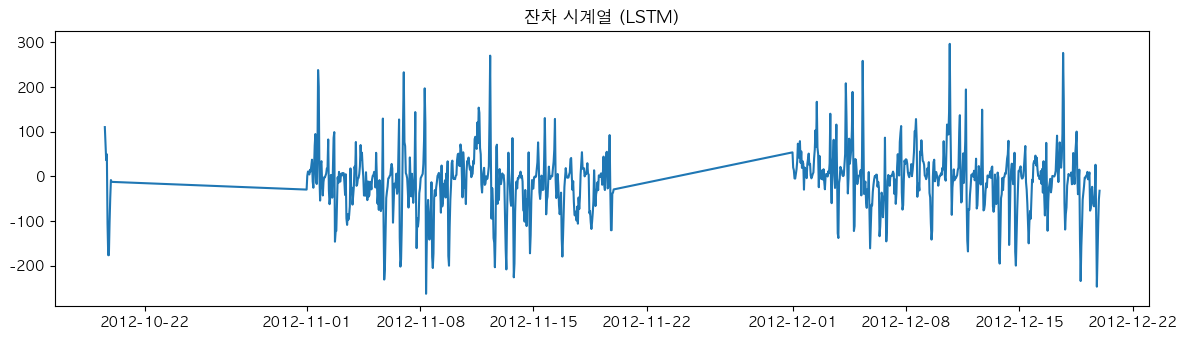

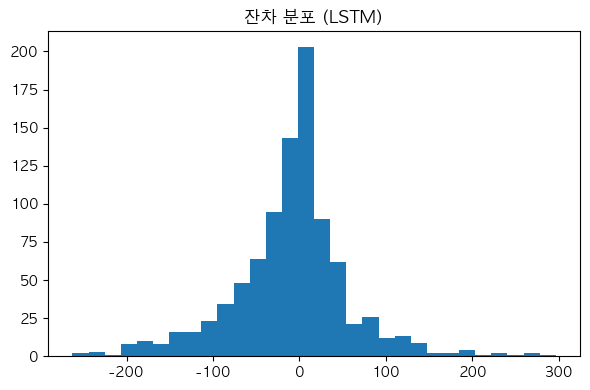

In [16]:
# -----------------------------
# 로그 변환된 타깃을 원래 스케일로 복원
# -----------------------------
if 'use_log_target' in globals() and use_log_target:
    # 로그 변환 전 값으로 복원 (expm1 = exp(x) - 1)
    yva_true = np.expm1(yva_seq.squeeze(-1))   # 검증 실제값
    yte_true = np.expm1(yte_seq.squeeze(-1))   # 테스트 실제값
    val_pred_eval = np.expm1(val_pred)         # 검증 예측값
    test_pred_eval = np.expm1(test_pred)       # 테스트 예측값
else:
    # 로그 변환을 사용하지 않았다면 그대로 사용
    yva_true = yva_seq.squeeze(-1)
    yte_true = yte_seq.squeeze(-1)
    val_pred_eval = val_pred
    test_pred_eval = test_pred


# -----------------------------
# 성능 평가 (검증/테스트)
# -----------------------------
print('LSTM/VAL', compute_metrics(yva_true, val_pred_eval))   # 검증 성능
print('LSTM/TEST', compute_metrics(yte_true, test_pred_eval)) # 테스트 성능
# → MAE, MSE, RMSE, R² 출력


# -----------------------------
# 잔차 분석 (Residual Analysis)
# -----------------------------
# 실제값 - 예측값 = 잔차
residual = yte_true - test_pred_eval

# 1) 잔차 시계열 플롯
plt.figure(figsize=(12,3.5))
plt.plot(test_idx, residual)
plt.title('잔차 시계열 (LSTM)')
plt.tight_layout()
plt.show()
# → 시간에 따라 잔차가 패턴 없이 랜덤하게 분포하면 모델 적합이 양호
# → 특정 구간에서 편향이 나타나면 해당 시점 패턴을 모델이 학습 못했을 가능성

# 2) 잔차 분포 히스토그램
plt.figure(figsize=(6,4))
plt.hist(residual, bins=30)
plt.title('잔차 분포 (LSTM)')
plt.tight_layout()
plt.show()
# → 잔차가 0을 중심으로 정규분포에 가까운 종 모양이면 이상적
# → 치우침(skew)이나 꼬리(tail)가 길면 특정 구간에서 예측 오차가 큼



### 4-4 LSTM 잔차 분석 결과

---

#### 1) 잔차 시계열 (첫 번째 그래프)  
- 잔차가 **0을 중심으로 위아래로 요동**함.  
- 특정 시점(예: 11월 초, 12월 초)에 **예측 오차가 크게 튀는 구간** 존재 → 모델이 특수 이벤트(날씨 급변, 휴일, 프로모션 등)를 반영하지 못했을 가능성.  
- 잔차가 완전히 랜덤하지 않고 구간별로 묶여 보임 → 시계열적 패턴(주간/요일 효과 등)을 충분히 학습하지 못했음을 시사.  

---

#### 2) 잔차 분포 히스토그램 (두 번째 그래프)  
- **0을 중심으로 한 좌우 대칭 종 모양(정규분포형)**에 가까움.  
- 꼬리가 다소 두꺼움(±200 이상 구간에도 잔차 존재) → 특정 extreme outlier 상황에서 큰 오차 발생.  
- 중앙에 데이터가 몰려 있음 → 대부분 구간에서는 예측 정확도가 괜찮음.  

---

#### 3) 종합 해석  
- **장점**  
  - 평균적으로는 예측을 잘함 (잔차가 0 근처에 집중).  
  - 좌우 대칭 분포 → 체계적인 편향(bias)은 크지 않음.  

- **한계**  
  - 특정 기간(이벤트성 날씨, 휴일 등)에서 오차가 크게 발생.  
  - 잔차가 백색잡음(white noise) 수준은 아님 → 패턴이 남아 있음.  



